# FYI directions, delete later

You are to build upon the predictive analysis (classification) that you already completed in the previous mini-project, adding additional modeling from new classification algorithms as well as more explanations that are inline with the CRISP-DM framework. You should use appropriate cross validation for all of your analysis (explain your chosen method of performance validation in detail). Try to use as much testing data as possible in a realistic manner (you should define what you think
is realistic and why). 

This report is worth 20% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a single document. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered Jupyter notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Dataset Selection

Select a dataset identically to the way you selected for the first project work week and mini-project.
You are not required to use the same dataset that you used in the past, but you are encouraged.
You must identify two tasks from the dataset to regress or classify. That is:

* two classification tasks OR
* two regression tasks OR
* one classification task and one regression task

For example, if your dataset was from the diabetes data you might try to predict two tasks: (1)
classifying if a patient will be readmitted within a 30 day period or not, and (2) regressing what the
total number of days a patient will spend in the hospital, given their history and specifics of the
encounter like tests administered and previous admittance.

# Lab 2: Zillow Dataset Classification 
MSDS 7331 Data Mining - Section 403 - Lab 2

Team: Ivelin Angelov, Yao Yao, Kaitlin Kirasich, Albert Asuncion

<a id="top"></a>
## Contents
* <a href="#Imports">Imports</a>
* <a href="#Define">Define and Prepare Class Variables</a>
* <a href="#Describe">Describe the Final Dataset</a>
* <a href="#Evaluation">Explain Evaluation Metrics</a>
* <a href="#Splits">Training and Testing Splits</a>
* <a href="#Models">Three Different Classification/Regression Models</a>
* <a href="#Analysis">Visualizations of Results and Analysis</a>
* <a href="#Advantages">Advantages of Each Model</a>
* <a href="#Attributes">Important Attributes</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>
* <a href="#References">References</a>
________________________________________________________________________________________________________
<a id="Imports"></a>
# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

<a href="#top">Back to Top</a>
<a id="Define"></a>
# Define and Prepare Class Variables
<b>10 points</b>

<i>
<b>Description:</b><br/>
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
</i>

In [2]:
variables = pd.read_csv('../../datasets/variables.csv').set_index('name')
dataset = pd.read_csv('../../datasets/train.csv', low_memory=False)

# remove unneeded variables
del dataset['logerror']
del dataset['transactiondate']
del dataset['city']
del dataset['price_per_sqft']

nominal = variables[variables['type'].isin(['nominal'])]
nominal = nominal[nominal.index.isin(dataset.columns)]
continuous = variables[~variables['type'].isin(['nominal'])]
continuous = continuous[continuous.index.isin(dataset.columns)]

nominal_data = dataset[nominal.index]
nominal_data = pd.get_dummies(nominal_data, drop_first=True)
nominal_data = nominal_data[nominal_data.columns[~nominal_data.columns.isin(nominal.index)]]

continuous_data = dataset[continuous.index]

dataset = pd.concat([continuous_data, nominal_data], axis=1)

columns = dataset.columns
variables = variables[variables.index.isin(dataset.columns)]

# shuffle the dataset (just in case)
dataset = dataset.sample(frac=1)

'The dataset has %d rows and %d columns' % dataset.shape

'The dataset has 116761 rows and 2107 columns'

## Regression task

In this dataset we will predict the value of taxamount

In [3]:
X = dataset.copy()
y = X['taxamount']
del X['taxamount']
# del X['taxvaluedollarcnt']????

dataset_reg = {
    'X': X,
    'y': y
}

## Classification task
I this task we are creating a variable: has_garage with posible values 1 or 0 representing has garage or doesn't have garage. The class is a little bit skewed with only 0.368 percent having garage.

In [4]:
X = dataset.copy()
y = (X['garagecarcnt'] > 0).astype(int)
del X['garagetotalsqft']
del X['garagecarcnt']

dataset_class = {
    'X': X,
    'y': y
}

y.sum() / len(X)

0.36825652401058573

<a href="#top">Back to Top</a>
<a id="Describe"></a>
# Describe the Final Dataset
<b>5 points</b>

<i>
<b>Description:</b><br/>
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</i>

## List of all variables

In [5]:
def output_variables_table(variables):
    variables = variables.sort_index()
    rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
    for vname, atts in variables.iterrows():
        atts = atts.to_dict()
        # add scale if TBD
        if atts['scale'] == 'TBD':
            if atts['type'] in ['nominal', 'ordinal']:
                uniques = dataset[vname].unique()
                uniques = list(uniques.astype(str))
                if len(uniques) < 10:
                    atts['scale'] = '[%s]' % ', '.join(uniques)
                else:
                    atts['scale'] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))
            if atts['type'] in ['ratio', 'interval']:
                atts['scale'] = '(%d, %d)' % (dataset[vname].min(), dataset[vname].max())
        row = (vname, atts['type'], atts['scale'], atts['description'])
        rows.append('<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % row)
    return HTML('<table>%s</table>' % ''.join(rows))

output_variables_table(variables)

Variable,Type,Scale,Description
assessmentyear,interval,"(2015, 2015)",The year of the property tax assessment
bathroomcnt,ordinal,"[4.0, 1.0, 2.0, 3.0, 7.0, ... (23 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[8, 3, 5, 1, 9, ... (17 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[4, 7, 1, 10, 8, 12, 6, 11]",Overall assessment of condition of the building from best (lowest) to worst (highest)
calculatedbathnbr,ordinal,"[4.0, 1.0, 2.0, 3.0, 7.0, ... (23 More)]",Number of bathrooms in home including fractional bathroom
calculatedfinishedsquarefeet,ratio,"(0, 10925)",Calculated total finished living area of the home
finishedsquarefeet12,ratio,"(0, 6615)",Finished living area
finishedsquarefeet50,ratio,"(0, 8352)",Size of the finished living area on the first (entry) floor of the home
fireplacecnt,ordinal,"[0, 3, 1, 2, 4, 5]",Number of fireplaces in a home (if any)
fullbathcnt,ordinal,"[4.0, 1.0, 2.0, 3.0, 7.0, ... (19 More)]","Number of full bathrooms (sink, shower + bathtub, and toilet) present in home"


<a href="#top">Back to Top</a>
<a id="Evaluation"></a>
# Explain Evaluation Metrics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</i>

For our evaluation, we will be taking into account the accuracy and F-measure.  In order to compute the F-measure, we will need the precision and recall.  Because F-measure is a weighted average of these, we think a better F-measure score means the model has a better precision and recall.

Accuracy is the ratio of correct predictions to the total number of observations. It is calculated as: (TP+TN) / (TP+FP+FN+TN). The closer accuracy is to 1, the more accurate the model is, with one caveat. For high accuracy to be a reliable indicator, the dataset has to be symmetric, i.e. total false positives are about equal to false negatives. Otherwise, we need to review other parameters as well.

Precision is the ratio of correctly predicted positive observations to the total positive observations. It is calculated as: TP / (TP+FP).  

Recall is the ratio of correctly predicted positive observations to all actual positives. It is calculated as TP / (TP+FN). The consequences of type 2 errors, predicting a false negative, are not extreme so we think recall is an appropriate measure of completeness.

Finally, we will also use F-measure which is essentially a weighted average of the precision and recall into one simple statistic. F-measure This will be a number between 0 and 1 where closer to 1 is better and approaching 0 is worse. It overcomes the limitations of accuracy whenever false positives and false negatives are not about equal or symmetric.

<a href="#top">Back to Top</a>
<a id="Imports"></a>
# Training and Testing Splits
<b>10 points</b>

<i>
<b>Description:</b><br/>
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</i>

# TODO build chart of train size while accuracy continues to increase

We have a large dataset so 10 fold cross validation may take too long.  Because of this, we will be splitting our dataset into 80% train and 20% test.

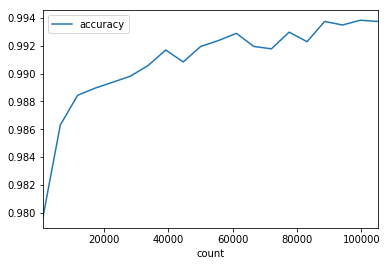

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

X = dataset_class['X']
y = dataset_class['y']
X, X_test, y, y_test = train_test_split(X, y, test_size=.1, random_state=0)

result = []

# uniform distribution values between 0 and 1
mask = np.random.rand(len(X))

for frac in np.linspace(.01, 1, 20):
    mask_frac = mask<=frac
    X_frac = X[mask_frac]
    y_frac = y[mask_frac]
    
    clf = RandomForestClassifier()
    clf.fit(X_frac, y_frac)
    y_hat = clf.predict(X_test)
    
    result.append({
        'accuracy': mt.accuracy_score(y_test, y_hat),
        'count': len(X_frac),
        'frac': frac
    })

pd.DataFrame(result).plot('count', 'accuracy')


<a href="#top">Back to Top</a>
<a id="Models"></a>
# Three Different Classification/Regression Models
<b>20 points</b>

<i>
<b>Description:</b><br/>
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</i>

## Kaitlin - 3 classification models

In [7]:
# Code for train test split
# Start with 80/20 split.  Keep same test and train for each classification model for now
X = dataset_class['X']
y = dataset_class['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


In [8]:
# Import metrics standard across all
from sklearn import metrics as mt
# Define an accuracy plot
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
# Plot the feature importances of the forest
def plot_feature_importance(ytrue,yhat,rt, title=''):
    importances = rt.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rt.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

## Correcting for class imbalance prior to performing classification
## TODO: Brief description of imbalanced-learn
### 1. Random over/under sampling
### 2. SMOTE, SMOTEENN
### 3. ADASYN
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

In [10]:
# Authors: Christos Aridas
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter

print(__doc__)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)

# Apply the random over-sampling
#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
#X_res_vis = pca.transform(X_resampled)

# Apply SMOTE + ENN
#sm = SMOTE()
#X_resampled, y_resampled = sm.fit_sample(X, y)
#X_res_vis = pca.transform(X_resampled)

# Apply ADASYN
ada = ADASYN()
X_resampled, y_resampled = ada.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

print('Before Resampling', sorted(Counter(y_train).items()))
print('After Resampling', sorted(Counter(y_resampled).items()))

Automatically created module for IPython interactive environment
Before Resampling [(0, 58946), (1, 34462)]
After Resampling [(0, 73763), (1, 73930)]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold

result = []
scores = []
seed = 0

for n_neighbors in range(15, 25):
    
    yhat = np.zeros(y.shape) # we will fill this with predictions
    cv = StratifiedKFold(n_splits=10, random_state=seed)
    for train_index, test_index in cv.split(X, y):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        yhat[test_index] = clf.predict(X_test)

    accuracy = mt.accuracy_score(y, yhat)
    print ('n_neighbors:', n_neighbors, 'accuracy:', accuracy)
    result.append({
        'accuracy': accuracy,
        'count': len(X_train),
        'n_neighbors': n_neighbors
    })

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Optimizing KNN
The first optimization we wanted to run was for the number of neighbors used in KNN.  From 1 to 20 neighbors, the accuracy continued to climb.  However, after 20 neighbors, our accuracy began to decline.  Our accuracy from 15 to 24 neighbors averaged out to about 0.68 (+/- 0.01).

Next, we will optimize for uniform vs distance weight functions, values of the power parameter (p), algorithm used to compute the nearest neighbors, and if applicable, leaf size.

<b>Weights</b><br>
weights='uniform' Accuracy: 0.68 (+/- 0.00)<br>
weights='distance' Accuracy: 0.67 (+/- 0.01)<br>
Uniform performed slightly better than distance.<br>

<b>Algorithm</b><br>
algorithm='auto' Accuracy: 0.68 (+/- 0.00)<br>
algorithm='ball_tree' Accuracy: 0.68 (+/- 0.00)<br>
algorithm='kd_tree' Accuracy: 0.68 (+/- 0.00)<br>
algorithm='brute' Accuracy: 0.68 (+/- 0.00)<br>
While the accuracy did not change when updating the algorithm, the 'brute' algorithm ran the entire loop in about the amount of time it took for the rest to run one instance.<br>

<b>Leaf Size</b><br>
We are not using a Ball tree or KD tree so our leaf_size will not effect accuracy.<br>

<b>P</b><br>
p=1 Accuracy: 0.68 (+/- 0.01)<br>
p=2 Accuracy: 0.68 (+/- 0.00)<br>
p=3 Accuracy: 0.69 (+/- 0.00)<br>
While we did get better results with p = 3, it did take noticably longer to run.  We are curious to see what the run time is like if we combine p=3 and algorithm='brute'.<br>

<b>Final Model</b><br>
For our final model, we ran KNeighborsClassifier(n_neighbors=20, p = 3, weights='uniform', algorithm='brute') and got the following results: <br>
 Accuracy 0.687777777778<br>
 Precision 0.360922146636<br>
 Recall 0.340655193237<br>
 F-measure 0.293679308051<br>

In [ ]:
# Final KNN model
    
scores = []
yhat = np.zeros(y.shape) # we will fill this with predictions
cv = StratifiedKFold(n_splits=10, random_state=seed)
for train_index, test_index in cv.split(X, y):
    clf = KNeighborsClassifier(n_neighbors=20, p = 3, weights='uniform', algorithm='brute')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    yhat[test_index] = clf.predict(X_test)
    
    accuracy = mt.accuracy_score(y_test, clf.predict(X_test))
    scores.append(accuracy)


scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print_accuracy('KNeighborsClassifier', y, yhat)
confusion_matrix(y, yhat, clf.classes_)

KNN accuracy 0.989594484649
KNN Precision 0.986850459498
KNN Recall 0.991015740048
KNN F-measure 0.988860632354


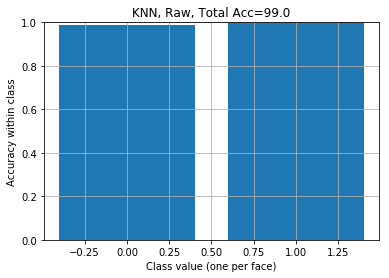

In [68]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_resampled, y_resampled)

# predict the response
yhat = knn.predict(X_test)

# evaluate accuracy
print ('KNN accuracy', mt.accuracy_score(y_test, yhat))
prf = mt.precision_recall_fscore_support(y_test, yhat, average='macro')
print('KNN Precision', prf[0])
print('KNN Recall', prf[1])
print('KNN F-measure', prf[2])
plot_class_acc(y_test,yhat,title="KNN, Raw")

Random Forest Accuracy 0.994047873935
Random Forest Precision 0.992447622838
Random Forest Recall 0.99482999479
Random Forest F-measure 0.993615999892


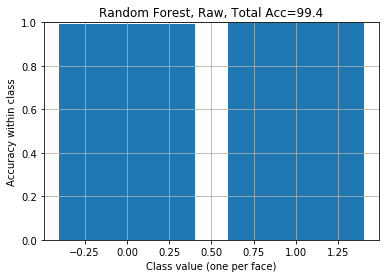

In [22]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# instantiate learning model
rf = RandomForestClassifier(max_depth=50)

# fitting the model
rf.fit(X_train, y_train)

# predict the response
yhat = rf.predict(X_test)

# evaluate accuracy
print ('Random Forest Accuracy', mt.accuracy_score(y_test, yhat))
prf = mt.precision_recall_fscore_support(y_test, yhat, average='macro')
print('Random Forest Precision', prf[0])
print('Random Forest Recall', prf[1])
print('Random Forest F-measure', prf[2])
plot_class_acc(y_test,yhat,title="Random Forest, Raw")

Random Forest Feature ranking:
1. feature 11 (0.143432)
2. feature 85 (0.143087)
3. feature 10 (0.104746)
4. feature 15 (0.078871)
5. feature 29 (0.054191)


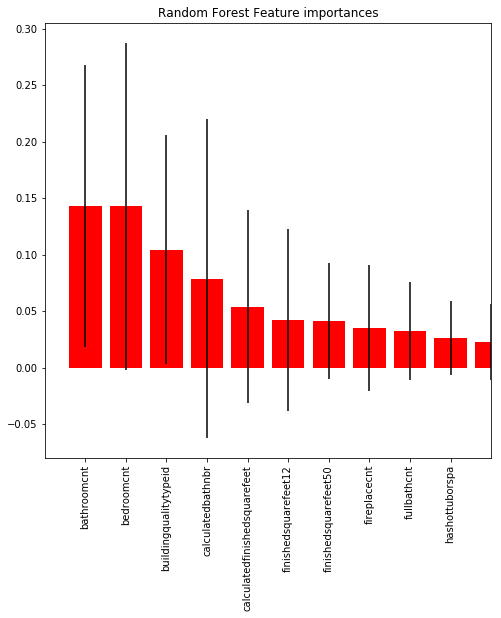

In [23]:
# Feature importance of Random Forest
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature ranking:")

for f in range(X.shape[1]):
    if importances[indices[f]] > 0.05:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8,8))
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
   color="r", yerr=std[indices], align="center")
feature_names = X.columns
plt.xticks(range(10), feature_names)
plt.xticks(rotation=90)
plt.xlim([-1, 10])
plt.show()

Naive Bayes Accuracy 0.786708345823
Naive Bayes Precision 0.859907450586
Naive Bayes Recall 0.712933484888
Naive Bayes F-measure 0.727047765183


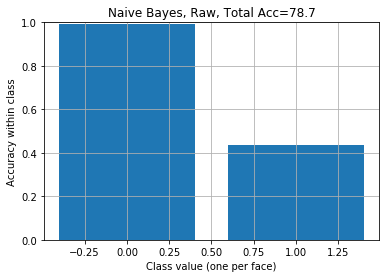

In [24]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# instantiate learning model
gnb = GaussianNB()

# fitting the model
gnb.fit(X_train, y_train)

# predict the response
yhat = gnb.predict(X_test)

# evaluate accuracy
print ('Naive Bayes Accuracy', mt.accuracy_score(y_test, yhat))
prf = mt.precision_recall_fscore_support(y_test, yhat, average='macro')
print('Naive Bayes Precision', prf[0])
print('Naive Bayes Recall', prf[1])
print('Naive Bayes F-measure', prf[2])
plot_class_acc(y_test,yhat,title="Naive Bayes, Raw")

<a href="#top">Back to Top</a>
<a id="Analysis"></a>
# Visualizations of Results and Analysis
<b>10 points</b>

<i>
<b>Description:</b><br/>
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</i>

<a href="#top">Back to Top</a>
<a id="Advantages"></a>
# Advantages of Each Model
<b>10 points</b>

<i>
<b>Description:</b><br/>
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</i>

<a href="#top">Back to Top</a>
<a id="Attributes"></a>
# Important Attributes
<b>10 points</b>

<i>
<b>Description:</b><br/>
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</i>

<a href="#top">Back to Top</a>
<a id="Deployment"></a>
# Deployment
<b>5 points</b>

<i>
<b>Description:</b><br/>
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</i>

<a href="#top">Back to Top</a>
<a id="Exceptional"></a>
# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</i>

Automatically created module for IPython interactive environment


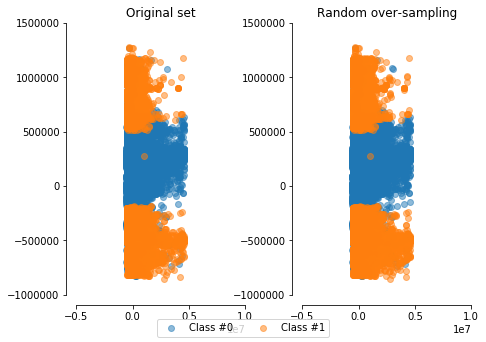

[(0, 73763), (1, 73763)]


In [64]:
# Authors: Christos Aridas
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter

print(__doc__)

# Generate the dataset
#X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
#                           n_informative=3, n_redundant=1, flip_y=0,
#                           n_features=20, n_clusters_per_class=1,
#                           n_samples=200, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)

# Apply the random over-sampling
#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
#X_res_vis = pca.transform(X_resampled)

# Apply SMOTE + ENN
#sm = SMOTE()
#X_resampled, y_resampled = sm.fit_sample(X, y)
#X_res_vis = pca.transform(X_resampled)

# Apply ADASYN
ada = ADASYN()
X_resampled, y_resampled = sm.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)


# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y_train == 0, 0], X_vis[y_train == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y_train == 1, 0], X_vis[y_train == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5)
ax2.set_title('Random over-sampling')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-5000000, 10000000])
    ax.set_ylim([-1000000, 1500000])

plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=-2)
plt.show()

print(sorted(Counter(y_resampled).items()))

<a href="#top">Back to Top</a>
<a id="References"></a>
# References:

- Kernels from Kaggle competition: https://www.kaggle.com/c/zillow-prize-1/kernels
- Scikitlearn logistic regression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikitlearn linear SVC: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Stackoverflow pandas questions: https://stackoverflow.com/questions/tagged/pandas